# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from langdetect import detect
import random
from random import shuffle
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger
from keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json

Using TensorFlow backend.


# 2. Import Data, Overview

In [2]:
data_reviews = pd.read_csv('steam_reviews.csv')

In [3]:
data_reviews.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [4]:
data_reviews.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


#### Checking if there are rows with empty cells:

In [5]:
data_reviews.isna().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64

In [6]:
data_reviews.dropna(inplace = True)
data_reviews.reset_index(drop = True, inplace = True)

In [7]:
data_reviews.shape

(433375, 8)

# 3. Preprocessing

## The result of all the pre-processing is saved in the file "Data_Processed.csv" and loaded in chapter 4

- The fisrt step is clean the reviews of the dataset of words that are not important for the analysis, remove every numerical data and puctuation, transform all the text into lowercase...etc

In [8]:
def clean(text_list, lemmatize, stemmer, stop_word):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z-zÀ-ÿ]", ' ', text)
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
            
        if stop_word:
            text = [w for w in text.split() if not w in stop]
            text = " ".join(text)
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"review": list_updated}))

- Here is a collection of English words that are considered as non important:

In [9]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [10]:
stop_words = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any',
 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before',
 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'd', 'did', 'didn', 'do', 'does', 'doing', 'don', 'down', 'during', 'each',
 'few', 'for', 'from', 'further', 'had', 'has', 'hasn', 'have', 'haven', 'having', 'he', 'her', 'here',
 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself',
 'just', 'll', 'm', 'ma', 'me', 'mightn', 'more',
 'most', 'mustn', 'my', 'myself', 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or',
 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're',
 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 't', 'than',
 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through',
 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'weren', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
 'why', 'will', 'with', 'won', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

In [11]:
updates = clean(data_reviews['review'], lemmatize = True, stemmer = False, stop_word = True)

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [12]:
update_df(data_reviews, updates)

- Next step is to calculate the number of words per review. With that values we are going to remove the reviews with just one word.
- The goal is to identify the reviews that are writed in English and simplify the data. It is neccesary more that one word in order to identify the language.

In [13]:
length_review = []
for i in range(0, len(data_reviews)):
    length_review.append(len(data_reviews['review'][i].split(' ')))

In [14]:
data_reviews['length_review'] = length_review

In [15]:
data_reviews.groupby('length_review').head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review
0,2019-02-10,2,4,578,False,Recommended,gt played german reich gt declare war belgium ...,Expansion - Hearts of Iron IV: Man the Guns,26
1,2019-02-10,0,0,184,False,Recommended,yes,Expansion - Hearts of Iron IV: Man the Guns,1
2,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17
3,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191
4,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132
...,...,...,...,...,...,...,...,...,...
431794,2017-09-07,0,0,21,False,Recommended,product received free update fall creator upda...,The Elder Scrolls V: Skyrim Special Edition,532
431995,2016-10-30,1,4,94,False,Recommended,product received free opinion game little wier...,The Elder Scrolls V: Skyrim Special Edition,516
432943,2017-10-04,0,0,138,False,Not Recommended,product received free tl drdecent change alrea...,The Elder Scrolls V: Skyrim Special Edition,680
433264,2019-01-03,0,0,10,False,Recommended,sonic blast also known sonic flickies island e...,Human: Fall Flat,775


In [16]:
data_reviews.groupby('length_review')['recommendation'].count().head(10)

length_review
1     43723
2     45964
3     32044
4     28987
5     24933
6     20532
7     17082
8     14766
9     13083
10    11592
Name: recommendation, dtype: int64

In [17]:
data_reviews = data_reviews[data_reviews['length_review'] > 1].reset_index(drop = True)

In [18]:
data_reviews.head(10)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review
0,2019-02-10,2,4,578,False,Recommended,gt played german reich gt declare war belgium ...,Expansion - Hearts of Iron IV: Man the Guns,26
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132
4,2016-12-12,4,55,2694,False,Recommended,english playing two year given task reviewing ...,Dead by Daylight,567
5,2017-09-17,12,228,48,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191
6,2018-12-24,295,219,71,False,Recommended,never told kill playing game,Dead by Daylight,5
7,2018-09-21,2,54,400,False,Recommended,longtime dead daylight player know horror game...,Dead by Daylight,164
8,2018-12-05,380,271,414,False,Recommended,think c go toxic try game,Dead by Daylight,6
9,2018-12-04,11,106,900,False,Recommended,simultaneously fun infuriating game played lon...,Dead by Daylight,170


- Next step is to detect the reviews writed in English. This process is slow. It takes around an hour...

In [19]:
language = []
for i in tqdm(range(0,len(data_reviews))):
    language.append(detect(data_reviews['review'][i]))

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [20]:
data_reviews['language'] = language

In [21]:
data_reviews.head(5)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language
0,2019-02-10,2,4,578,False,Recommended,gt played german reich gt declare war belgium ...,Expansion - Hearts of Iron IV: Man the Guns,26,nl
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en
4,2016-12-12,4,55,2694,False,Recommended,english playing two year given task reviewing ...,Dead by Daylight,567,es


- Transforming into a binary classification:

In [22]:
data_reviews.loc[data_reviews['recommendation'] == 'Not Recommended', 'Label'] = 0
data_reviews.loc[data_reviews['recommendation'] == 'Recommended', 'Label'] = 1

- Saving the processed dataset into a .csv file:

In [23]:
data_reviews.to_csv('Data_Processed.csv', index=False)

# 4) MODELS

### Every model created and trained during this notebook is saved in a .h5 file in order to be loaded when it is necessary with its history saved in a .csv file.

- Analyzing which is the most common language and keeping just the reviews writed in that language:

In [24]:
data_reviews = pd.read_csv('Data_Processed.csv')

In [25]:
data_reviews.groupby('language').count().sort_values(['recommendation'], ascending=False)['recommendation'].head(5)

language
en    297246
da     13821
so     11103
no      8531
af      7667
Name: recommendation, dtype: int64

In [26]:
data_reviewsEN = data_reviews[data_reviews['language'] == 'en']

In [27]:
data_reviewsEN.shape

(297246, 11)

In [28]:
data_reviewsEN.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language,Label
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en,1.0
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en,1.0
5,2017-09-17,12,228,48,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
7,2018-09-21,2,54,400,False,Recommended,longtime dead daylight player know horror game...,Dead by Daylight,164,en,1.0


In [29]:
data_reviews.groupby('recommendation').count()['Label']

recommendation
Not Recommended    121306
Recommended        268346
Name: Label, dtype: int64

### 4.1) Preparing the training, validation and test set:

In [30]:
English_reviews = data_reviewsEN.sample(frac=0.7, random_state=1)

- Creating vectors with n-grams between 1 and 3 words:

In [31]:
vectorizer = CountVectorizer(max_df = 0.9, min_df=0.003, max_features= 2500, binary= False, ngram_range=(1, 3))

In [32]:
train = vectorizer.fit_transform(English_reviews['review'])

In [33]:
target = English_reviews['Label']

In [34]:
target

341269    1.0
338420    0.0
280475    1.0
210089    1.0
73039     1.0
         ... 
204180    0.0
81900     1.0
195257    0.0
60691     0.0
148883    1.0
Name: Label, Length: 208072, dtype: float64

In [35]:
train = train.toarray()

In [36]:
train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

- Spitting the data:

In [37]:
X_train, x_val_test, y_train, y_val_test = train_test_split(train, target,
                                                    test_size = 0.3,
                                                    random_state = 500
                                                    ,stratify = target)

In [38]:
X_val, X_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                    test_size = 0.3,
                                                    random_state = 200
                                                    ,stratify = y_val_test)

In [39]:
X_train.shape

(145650, 1641)

In [40]:
X_val.shape

(43695, 1641)

In [41]:
X_test.shape

(18727, 1641)

### 4.2) Building and Training the models:

##### First Model (simple):

- Due to the imbalanced dataset where there are half of non-recommended than recommended games, we will based our evaluation in the "accuracy" and "f1_score". Being "f1_score" one of the most used metrics to evaluate the results of models trained with imbalanced datasets.

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

- The first model is a simple model with just one layer and 16 elements:

In [43]:
model = Sequential()

model.add(Dense(16,activation = 'relu', input_dim = len(train[1])))
model.add(Dense(1,activation = 'sigmoid'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                26272     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 26,289
Trainable params: 26,289
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [46]:
csv_logger = CSVLogger('model_simple.log', separator=',', append=False)

In [47]:
history = model.fit(X_train,
                    y_train,
                    epochs = 30,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/30
145650/145650 [==============================] - 6s 44us/sample - loss: 0.4186 - f1_m: 0.8748 - accuracy: 0.8302 - val_loss: 0.3706 - val_f1_m: 0.8880 - val_accuracy: 0.8476
Epoch 2/30
145650/145650 [==============================] - 3s 23us/sample - loss: 0.3484 - f1_m: 0.8927 - accuracy: 0.8543 - val_loss: 0.3448 - val_f1_m: 0.8894 - val_accuracy: 0.8506
Epoch 3/30
145650/145650 [==============================] - 3s 23us/sample - loss: 0.3263 - f1_m: 0.8959 - accuracy: 0.8598 - val_loss: 0.3362 - val_f1_m: 0.8902 - val_accuracy: 0.8534
Epoch 4/30
145650/145650 [==============================] - 3s 23us/sample - loss: 0.3152 - f1_m: 0.8987 - accuracy: 0.8642 - val_loss: 0.3345 - val_f1_m: 0.8906 - val_accuracy: 0.8536
Epoch 5/30
145650/145650 [==============================] - 4s 24us/sample - loss: 0.3075 - f1_m: 0.9011 - accuracy: 0.8676 - val_loss: 0.3327 - val_f1_m: 0.8918 - val_accuracy: 0.8552
Epoch 6/30
145650/145650

In [48]:
#Saving the model:
model.save('model_simple.h5')

- Plot of the three parameters evaluated in the model:

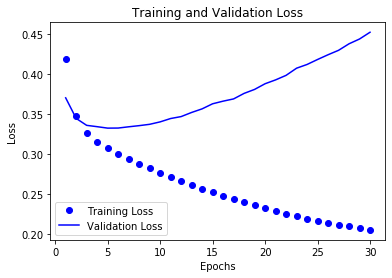

In [49]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

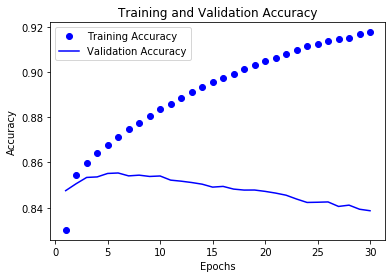

In [50]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

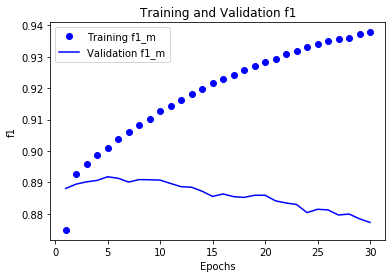

In [51]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [52]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 37us/sample - loss: 0.4447 - f1_m: 0.8786 - accuracy: 0.8430


In [53]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.44465154416559965
The f1_score is:  0.8785892
The accuracy is:  0.84295404


                                     ##### The model is crearly overfitted #####

##### Second Model (medium-complex):

In [54]:
model = Sequential()

model.add(Dense(64,activation = 'relu', input_dim = len(train[1])))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                105088    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 109,313
Trainable params: 109,313
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [57]:
csv_logger = CSVLogger('model_medium-complex.log', separator=',', append=False)

In [58]:
history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/10
145650/145650 [==============================] - 5s 33us/sample - loss: 0.3646 - f1_m: 0.8831 - accuracy: 0.8405 - val_loss: 0.3319 - val_f1_m: 0.8920 - val_accuracy: 0.8555
Epoch 2/10
145650/145650 [==============================] - 4s 28us/sample - loss: 0.3090 - f1_m: 0.9004 - accuracy: 0.8674 - val_loss: 0.3303 - val_f1_m: 0.8913 - val_accuracy: 0.8553
Epoch 3/10
145650/145650 [==============================] - 4s 27us/sample - loss: 0.2829 - f1_m: 0.9100 - accuracy: 0.8803 - val_loss: 0.3313 - val_f1_m: 0.8910 - val_accuracy: 0.8553
Epoch 4/10
145650/145650 [==============================] - 6s 40us/sample - loss: 0.2535 - f1_m: 0.9209 - accuracy: 0.8949 - val_loss: 0.3542 - val_f1_m: 0.8872 - val_accuracy: 0.8521
Epoch 5/10
145650/145650 [==============================] - 7s 49us/sample - loss: 0.2230 - f1_m: 0.9323 - accuracy: 0.9101 - val_loss: 0.3758 - val_f1_m: 0.8856 - val_accuracy: 0.8499
Epoch 6/10
145650/145650

In [59]:
#Saving the model:
model.save('model_medium-complex.h5')

- Plot of the three parameters evaluated in the model:

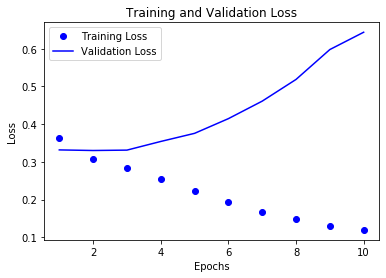

In [60]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

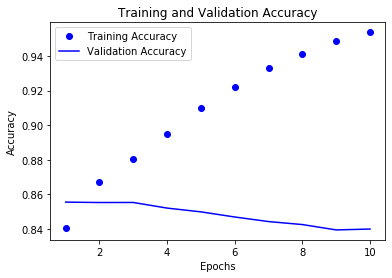

In [61]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

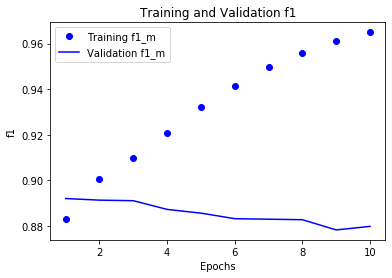

In [62]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [63]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 39us/sample - loss: 0.6324 - f1_m: 0.8778 - accuracy: 0.8397


In [64]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.63237733358904
The f1_score is:  0.8777612
The accuracy is:  0.8396967


                      ##### The model is crearly overfitted and worse than the simple model#####

# 5) Handling Overfitting

Now, we can try to do something about the overfitting. We are going to try three different options to do that:
    - Reduce the network’s capacity by removing layers or reducing the number of elements in the hidden layers
    - Apply regularization, which comes down to adding a cost to the loss function for large weights
    - Use Dropout layers, which will randomly remove certain features by setting them to zero

##### 1) Reduce the number of elements:

In [65]:
model = Sequential()

model.add(Dense(8,activation = 'relu', input_dim = len(train[1])))
model.add(Dense(1,activation = 'sigmoid'))

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 13136     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 13,145
Trainable params: 13,145
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [68]:
csv_logger = CSVLogger('model_simple_reduce_elements.log', separator=',', append=False)

In [69]:
history = model.fit(X_train,
                    y_train,
                    epochs = 30,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/30
145650/145650 [==============================] - 4s 28us/sample - loss: 0.4277 - f1_m: 0.8756 - accuracy: 0.8256 - val_loss: 0.3872 - val_f1_m: 0.8842 - val_accuracy: 0.8415
Epoch 2/30
145650/145650 [==============================] - 4s 25us/sample - loss: 0.3712 - f1_m: 0.8886 - accuracy: 0.8477 - val_loss: 0.3629 - val_f1_m: 0.8857 - val_accuracy: 0.8453
Epoch 3/30
145650/145650 [==============================] - 3s 23us/sample - loss: 0.3449 - f1_m: 0.8916 - accuracy: 0.8540 - val_loss: 0.3468 - val_f1_m: 0.8879 - val_accuracy: 0.8497
Epoch 4/30
145650/145650 [==============================] - 5s 37us/sample - loss: 0.3297 - f1_m: 0.8944 - accuracy: 0.8586 - val_loss: 0.3396 - val_f1_m: 0.8886 - val_accuracy: 0.8522
Epoch 5/30
145650/145650 [==============================] - 6s 43us/sample - loss: 0.3203 - f1_m: 0.8964 - accuracy: 0.8617 - val_loss: 0.3349 - val_f1_m: 0.8922 - val_accuracy: 0.8558
Epoch 6/30
145650/145650

In [70]:
#Saving the model:
model.save('model_simple_reduce_elements.h5')

- Plot of the three parameters evaluated in the model:

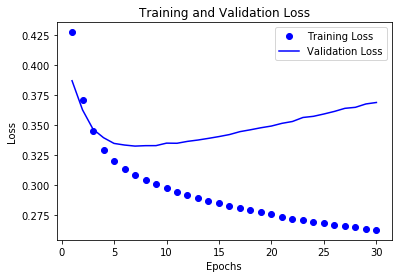

In [71]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

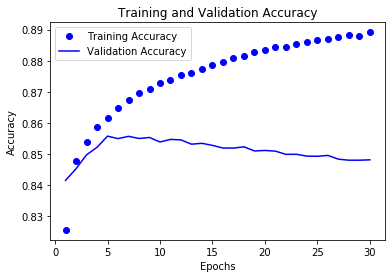

In [72]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

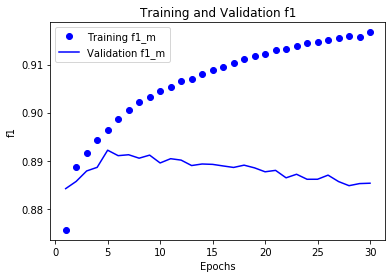

In [73]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [74]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 37us/sample - loss: 0.3627 - f1_m: 0.8844 - accuracy: 0.8498


In [75]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.3627166340514797
The f1_score is:  0.8843881
The accuracy is:  0.8497891


                      ##### The model is crearly overfitted. Reducing the number of layers
                   and number of elements is not a solution for the overfitting problem ##### 

##### 2) Apply regularization, which comes down to adding a cost to the loss function for large weights:

In [76]:
model = Sequential()

model.add(Dense(16,kernel_regularizer=regularizers.l2(0.005),activation = 'relu', input_dim = len(train[1])))
model.add(Dense(1,activation = 'sigmoid'))

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                26272     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 26,289
Trainable params: 26,289
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [79]:
csv_logger = CSVLogger('model_simple_regularization.log', separator=',', append=False)

In [80]:
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/50
145650/145650 [==============================] - 4s 28us/sample - loss: 0.4909 - f1_m: 0.8679 - accuracy: 0.8131 - val_loss: 0.4425 - val_f1_m: 0.8766 - val_accuracy: 0.8266
Epoch 2/50
145650/145650 [==============================] - 3s 24us/sample - loss: 0.4271 - f1_m: 0.8811 - accuracy: 0.8352 - val_loss: 0.4169 - val_f1_m: 0.8812 - val_accuracy: 0.8345
Epoch 3/50
145650/145650 [==============================] - 3s 24us/sample - loss: 0.4070 - f1_m: 0.8850 - accuracy: 0.8421 - val_loss: 0.4037 - val_f1_m: 0.8851 - val_accuracy: 0.8443
Epoch 4/50
145650/145650 [==============================] - 5s 36us/sample - loss: 0.3972 - f1_m: 0.8868 - accuracy: 0.8455 - val_loss: 0.3951 - val_f1_m: 0.8865 - val_accuracy: 0.8450
Epoch 5/50
145650/145650 [==============================] - 7s 50us/sample - loss: 0.3915 - f1_m: 0.8879 - accuracy: 0.8475 - val_loss: 0.3947 - val_f1_m: 0.8849 - val_accuracy: 0.8437
Epoch 6/50
145650/145650

Epoch 45/50
145650/145650 [==============================] - 4s 29us/sample - loss: 0.3586 - f1_m: 0.8963 - accuracy: 0.8613 - val_loss: 0.3780 - val_f1_m: 0.8861 - val_accuracy: 0.8506
Epoch 46/50
145650/145650 [==============================] - 5s 33us/sample - loss: 0.3584 - f1_m: 0.8961 - accuracy: 0.8611 - val_loss: 0.3761 - val_f1_m: 0.8896 - val_accuracy: 0.8508
Epoch 47/50
145650/145650 [==============================] - 4s 25us/sample - loss: 0.3578 - f1_m: 0.8961 - accuracy: 0.8612 - val_loss: 0.3734 - val_f1_m: 0.8896 - val_accuracy: 0.8524
Epoch 48/50
145650/145650 [==============================] - 4s 26us/sample - loss: 0.3572 - f1_m: 0.8961 - accuracy: 0.8613 - val_loss: 0.3763 - val_f1_m: 0.8890 - val_accuracy: 0.8513
Epoch 49/50
145650/145650 [==============================] - 4s 24us/sample - loss: 0.3572 - f1_m: 0.8960 - accuracy: 0.8612 - val_loss: 0.3731 - val_f1_m: 0.8892 - val_accuracy: 0.8526
Epoch 50/50
145650/145650 [==============================] - 4s 26us/s

In [81]:
#Saving the model:
model.save('model_simple_regularization.h5')

- Plot of the three parameters evaluated in the model:

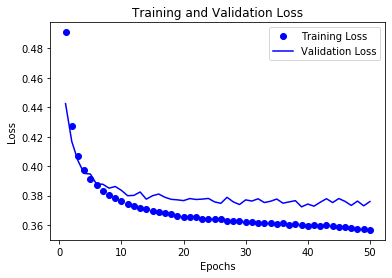

In [82]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

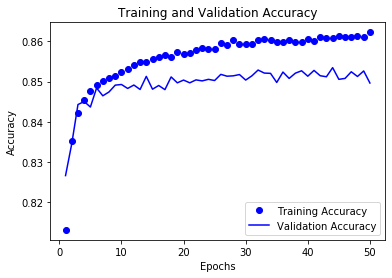

In [83]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

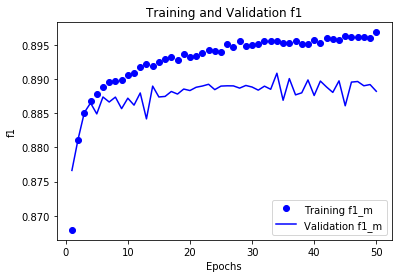

In [84]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [85]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 45us/sample - loss: 0.3715 - f1_m: 0.8894 - accuracy: 0.8539


In [86]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.37145427651410934
The f1_score is:  0.8894235
The accuracy is:  0.8539008


                      ##### The model is still a bit overfitted. But it is possible to observe how 
                     the difference between the training and the validation values is smaller.It can
                     be stopped with less epochs and get a good model. The regularization parameter
                                   really works resolving the overfitting problem. ##### 

##### 3) Use Dropout layers:

In [87]:
model = Sequential()

model.add(Dense(16,activation = 'relu', input_dim = len(train[1])))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))

In [88]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                26272     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 26,289
Trainable params: 26,289
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [90]:
csv_logger = CSVLogger('model_simple_dropout.log', separator=',', append=False)

In [91]:
history = model.fit(X_train,
                    y_train,
                    epochs = 30,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/30
145650/145650 [==============================] - 4s 29us/sample - loss: 0.4537 - f1_m: 0.8648 - accuracy: 0.8159 - val_loss: 0.3583 - val_f1_m: 0.8883 - val_accuracy: 0.8487
Epoch 2/30
145650/145650 [==============================] - 4s 25us/sample - loss: 0.3701 - f1_m: 0.8874 - accuracy: 0.8471 - val_loss: 0.3431 - val_f1_m: 0.8894 - val_accuracy: 0.8512
Epoch 3/30
145650/145650 [==============================] - 4s 27us/sample - loss: 0.3583 - f1_m: 0.8898 - accuracy: 0.8502 - val_loss: 0.3411 - val_f1_m: 0.8897 - val_accuracy: 0.8501
Epoch 4/30
145650/145650 [==============================] - 4s 25us/sample - loss: 0.3509 - f1_m: 0.8911 - accuracy: 0.8519 - val_loss: 0.3394 - val_f1_m: 0.8896 - val_accuracy: 0.8504
Epoch 5/30
145650/145650 [==============================] - 5s 32us/sample - loss: 0.3478 - f1_m: 0.8923 - accuracy: 0.8536 - val_loss: 0.3394 - val_f1_m: 0.8900 - val_accuracy: 0.8505
Epoch 6/30
145650/145650

In [92]:
#Saving the model:
model.save('model_simple_dropout.h5')

- Plot of the three parameters evaluated in the model:

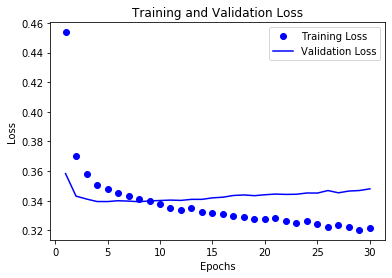

In [93]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

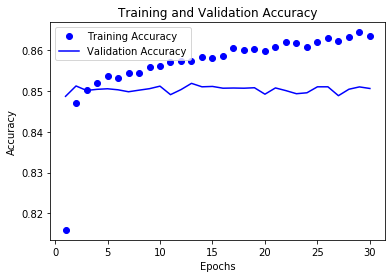

In [94]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

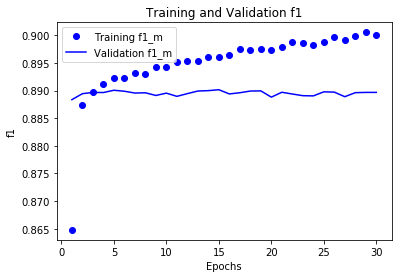

In [95]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [96]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 40us/sample - loss: 0.3429 - f1_m: 0.8900 - accuracy: 0.8533


In [97]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.34288372316905436
The f1_score is:  0.8899779
The accuracy is:  0.8533134


                      ##### The model is still a bit overfitted. But it is possible to observe how 
                        the difference between the training and the validation values is smaller. 
                               Dropout layer works resolving the overfitting problem. ##### 

#### After try three different methods we can assume that for this problem, the dropout layer and the regularization parameter help us to resolve the overfitting problem. Specially the regularization parameter do a better job about it. Because of it, we are going to try this parameter in more complex models and observe what happen.

In [109]:
model = Sequential()

model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu', input_dim = len(train[1])))
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [110]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                105088    
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 109,313
Trainable params: 109,313
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [112]:
csv_logger = CSVLogger('model_complex_regularization.log', separator=',', append=False)

In [113]:
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/50
145650/145650 [==============================] - 5s 34us/sample - loss: 0.5125 - f1_m: 0.8750 - accuracy: 0.8260 - val_loss: 0.4236 - val_f1_m: 0.8809 - val_accuracy: 0.8387
Epoch 2/50
145650/145650 [==============================] - 4s 28us/sample - loss: 0.4118 - f1_m: 0.8864 - accuracy: 0.8464 - val_loss: 0.4038 - val_f1_m: 0.8870 - val_accuracy: 0.8464
Epoch 3/50
145650/145650 [==============================] - 4s 30us/sample - loss: 0.3988 - f1_m: 0.8883 - accuracy: 0.8494 - val_loss: 0.3968 - val_f1_m: 0.8868 - val_accuracy: 0.8448
Epoch 4/50
145650/145650 [==============================] - 7s 47us/sample - loss: 0.3883 - f1_m: 0.8900 - accuracy: 0.8517 - val_loss: 0.3941 - val_f1_m: 0.8844 - val_accuracy: 0.8488
Epoch 5/50
145650/145650 [==============================] - 5s 37us/sample - loss: 0.3816 - f1_m: 0.8906 - accuracy: 0.8530 - val_loss: 0.3837 - val_f1_m: 0.8892 - val_accuracy: 0.8507
Epoch 6/50
145650/145650

Epoch 45/50
145650/145650 [==============================] - 4s 28us/sample - loss: 0.3548 - f1_m: 0.8953 - accuracy: 0.8603 - val_loss: 0.3707 - val_f1_m: 0.8908 - val_accuracy: 0.8523
Epoch 46/50
145650/145650 [==============================] - 4s 31us/sample - loss: 0.3541 - f1_m: 0.8952 - accuracy: 0.8600 - val_loss: 0.3632 - val_f1_m: 0.8908 - val_accuracy: 0.8549
Epoch 47/50
145650/145650 [==============================] - 6s 44us/sample - loss: 0.3541 - f1_m: 0.8951 - accuracy: 0.8600 - val_loss: 0.3664 - val_f1_m: 0.8875 - val_accuracy: 0.8517
Epoch 48/50
145650/145650 [==============================] - 5s 34us/sample - loss: 0.3547 - f1_m: 0.8952 - accuracy: 0.8602 - val_loss: 0.3645 - val_f1_m: 0.8892 - val_accuracy: 0.8534
Epoch 49/50
145650/145650 [==============================] - 4s 28us/sample - loss: 0.3543 - f1_m: 0.8947 - accuracy: 0.8596 - val_loss: 0.3641 - val_f1_m: 0.8914 - val_accuracy: 0.8545
Epoch 50/50
145650/145650 [==============================] - 4s 29us/s

In [114]:
#Saving the model:
model.save('model_complex_regularization.h5')

- Plot of the three parameters evaluated in the model:

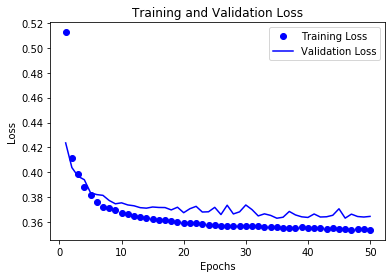

In [115]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

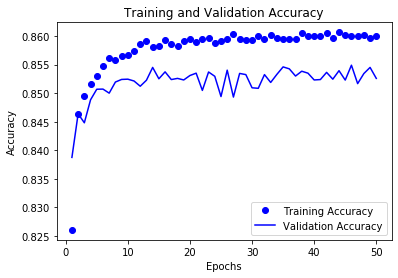

In [116]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

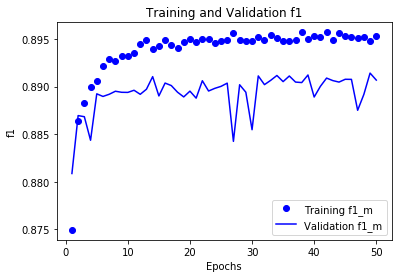

In [117]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [118]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 41us/sample - loss: 0.3587 - f1_m: 0.8925 - accuracy: 0.8569


In [119]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.3587223973005665
The f1_score is:  0.89248043
The accuracy is:  0.8569445


                      ##### The model get the best result for the moment. It is possible to observe 
                       that the difference between the training and the validation values is small. 
                         Regularization parameter works resolving the overfitting problem. ##### 

# 6) Data Augmentation

## 6.1) Processing:

### The results of all the process are saved in the file "X_train_augmentation.csv" and  "y_train_augmentation.csv" and loaded for train the model.

- In this section we are going to implement some function found on internet in order to have more data. And investigate if it is possible to improve the accuracy and the f1_score got it.

In [120]:
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [121]:
########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

from nltk.corpus import wordnet 

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            #print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n: #only replace up to n words
            break
    
    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [122]:
########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

In [123]:
########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=2):

    sentence = get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']
    num_words = len(words)
    
    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1
    n_sr = max(1, int(alpha_sr*num_words))
    n_ri = max(1, int(alpha_ri*num_words))
    n_rs = max(1, int(alpha_rs*num_words))

    #sr
    for _ in range(num_new_per_technique):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))

    #rs
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(' '.join(a_words))

    augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
    shuffle(augmented_sentences)

    #trim so that we have the desired number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    #append the original sentence
    augmented_sentences.append(sentence)

    return augmented_sentences

- Example of how it works: (It is neccesary to run the piece of code with the stop words in section 2)

In [124]:
eda('Hello, I am Victor. I am from Spain and I am 26 years old')

['hello i am victor i am from spain and i am years previous',
 'hello i am old i am from spain and i am years victor',
 'hello i am victor i am from spain and i am years old']

- For this section it is necessary to load again the processed data:

In [169]:
data_reviews = pd.read_csv('Data_Processed.csv')

In [170]:
data_reviews.groupby('language').count().sort_values(['recommendation'], ascending=False)['recommendation'].head(5)

language
en    297246
da     13821
so     11103
no      8531
af      7667
Name: recommendation, dtype: int64

In [171]:
data_reviewsEN = data_reviews[data_reviews['language'] == 'en']
data_reviewsEN.reset_index(drop = True, inplace = True)

In [172]:
data_reviewsEN.shape

(297246, 11)

In [173]:
data_reviewsEN.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language,Label
0,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en,1.0
1,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
2,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en,1.0
3,2017-09-17,12,228,48,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
4,2018-09-21,2,54,400,False,Recommended,longtime dead daylight player know horror game...,Dead by Daylight,164,en,1.0


In [174]:
data_reviewsEN.groupby('recommendation').count()['Label']

recommendation
Not Recommended    101440
Recommended        195806
Name: Label, dtype: int64

In [175]:
data_reviewsEN.columns

Index(['date_posted', 'funny', 'helpful', 'hour_played',
       'is_early_access_review', 'recommendation', 'review', 'title',
       'length_review', 'language', 'Label'],
      dtype='object')

- Split into data and target:

In [176]:
data = data_reviewsEN[['date_posted', 'funny', 'helpful', 'hour_played',
       'is_early_access_review', 'recommendation', 'review', 'title',
       'length_review', 'language']]
target = data_reviewsEN['Label']

- The data augmentation method is going to be implemented just on the training set:

In [177]:
X_train, x_val_test, y_train, y_val_test = train_test_split(data, target,
                                                    test_size = 0.3,
                                                    random_state = 500
                                                    ,stratify = target)

In [178]:
X_train.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language
171629,2017-08-08,0,0,208,True,Recommended,faster snail speed dayz pace slower h z cartoo...,PLAYERUNKNOWN'S BATTLEGROUNDS,90,en
114915,2017-02-25,0,0,2,False,Not Recommended,would good game worked laptop refund year ago,Grand Theft Auto V,8,en
64463,2017-07-16,0,0,1644,False,Recommended,far addicting game ever played literally becom...,Rocket League®,13,en
61402,2016-12-23,0,0,445,False,Recommended,initially think mix car football could addicti...,Rocket League®,16,en
94360,2017-12-02,0,0,562,False,Not Recommended,gta v great game gta online full hacker griefe...,Grand Theft Auto V,24,en


In [179]:
X_train.shape

(208072, 10)

In [180]:
X_train.reset_index(drop = True, inplace = True)

- For 10.000 reviews, we are going to apply the data augmentation, keeping the same label.

In [181]:
list_aug = []
for i in tqdm(range(10000)):
    list_aug.append([eda(X_train['review'][i]),target[i]])

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [182]:
df = pd.DataFrame(columns = data_reviewsEN.columns)
for i in tqdm(range(10000)):
    d = {'review': list_aug[i][0][0:2], 'Label': [list_aug[i][1],list_aug[i][1]]}
    df = pd.concat([df,pd.DataFrame(d, columns = ['review','Label'])], axis = 0)

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [183]:
df.reset_index(drop = True, inplace = True)

In [184]:
X_train = pd.concat([X_train,df[['date_posted', 'funny', 'helpful', 'hour_played',
       'is_early_access_review', 'recommendation', 'review', 'title',
       'length_review', 'language']]],axis = 0)
X_train.reset_index(drop = True, inplace = True)

In [185]:
X_train.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language
0,2017-08-08,0,0,208,True,Recommended,faster snail speed dayz pace slower h z cartoo...,PLAYERUNKNOWN'S BATTLEGROUNDS,90,en
1,2017-02-25,0,0,2,False,Not Recommended,would good game worked laptop refund year ago,Grand Theft Auto V,8,en
2,2017-07-16,0,0,1644,False,Recommended,far addicting game ever played literally becom...,Rocket League®,13,en
3,2016-12-23,0,0,445,False,Recommended,initially think mix car football could addicti...,Rocket League®,16,en
4,2017-12-02,0,0,562,False,Not Recommended,gta v great game gta online full hacker griefe...,Grand Theft Auto V,24,en


In [186]:
y_train = pd.concat([y_train,df['Label']],axis = 0)

In [187]:
X_train.shape

(228072, 10)

In [188]:
y_train.shape

(228072,)

In [189]:
X_train.tail(5)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language
228067,NaN,NaN,NaN,NaN,NaN,NaN,gta v single player one smart as a whip ambiti...,NaN,NaN,NaN
228068,NaN,NaN,NaN,NaN,NaN,NaN,cheat fact player wallhacking game get killcam...,NaN,NaN,NaN
228069,NaN,NaN,NaN,NaN,NaN,NaN,apart fact player wallhacking game scram killc...,NaN,NaN,NaN
228070,NaN,NaN,NaN,NaN,NaN,NaN,slow pace problem cuz mansion camper everythin...,NaN,NaN,NaN
228071,NaN,NaN,NaN,NaN,NaN,NaN,slow pace problem cuz house everything camper ...,NaN,NaN,NaN


In [190]:
X_train.to_csv('X_train_augmentation.csv', index=False)
y_train.to_csv('y_train_augmentation.csv', index=False)

## 6.2) Building and training the model:

In [191]:
X_train = pd.read_csv('X_train_augmentation.csv')
y_train = pd.read_csv('y_train_augmentation.csv')

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [192]:
X_train.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language
0,2017-08-08,0.0,0.0,208.0,True,Recommended,faster snail speed dayz pace slower h z cartoo...,PLAYERUNKNOWN'S BATTLEGROUNDS,90.0,en
1,2017-02-25,0.0,0.0,2.0,False,Not Recommended,would good game worked laptop refund year ago,Grand Theft Auto V,8.0,en
2,2017-07-16,0.0,0.0,1644.0,False,Recommended,far addicting game ever played literally becom...,Rocket League®,13.0,en
3,2016-12-23,0.0,0.0,445.0,False,Recommended,initially think mix car football could addicti...,Rocket League®,16.0,en
4,2017-12-02,0.0,0.0,562.0,False,Not Recommended,gta v great game gta online full hacker griefe...,Grand Theft Auto V,24.0,en


In [193]:
X_train.shape

(228072, 10)

In [194]:
y_train = y_train['Label']
y_train

0         1.0
1         0.0
2         1.0
3         1.0
4         0.0
         ... 
228067    1.0
228068    1.0
228069    1.0
228070    1.0
228071    1.0
Name: Label, Length: 228072, dtype: float64

In [195]:
vectorizer = CountVectorizer(max_df = 0.9, min_df=0.003, max_features= 1500, binary= False, ngram_range=(1, 3))

In [196]:
X_train.shape

(228072, 10)

In [197]:
train = vectorizer.fit_transform(X_train['review'])

In [198]:
train = train.toarray()

In [199]:
train.shape

(228072, 1500)

In [200]:
x_val_test.shape

(89174, 10)

In [201]:
x_val_test = vectorizer.fit_transform(x_val_test['review'])

In [202]:
x_val_test = x_val_test.toarray()

In [203]:
x_val_test.shape

(89174, 1500)

In [204]:
X_val, X_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                    test_size = 0.30,
                                                    random_state = 200
                                                    ,stratify = y_val_test)

- Using this data for the complex model:

In [205]:
model = Sequential()

model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu', input_dim = len(train[1])))
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [206]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                96064     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 100,289
Trainable params: 100,289
Non-trainable params: 0
_________________________________________________________________


In [207]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [208]:
csv_logger = CSVLogger('training_model_augmentation.log', separator=',', append=False)

In [209]:
history = model.fit(train,
                    y_train,
                    epochs = 30,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 228072 samples, validate on 62421 samples
Epoch 1/30
228072/228072 [==============================] - 7s 31us/sample - loss: 0.5215 - f1_m: 0.8607 - accuracy: 0.8058 - val_loss: 0.6959 - val_f1_m: 0.7682 - val_accuracy: 0.6684
Epoch 2/30
228072/228072 [==============================] - 6s 27us/sample - loss: 0.4548 - f1_m: 0.8680 - accuracy: 0.8200 - val_loss: 0.6999 - val_f1_m: 0.7404 - val_accuracy: 0.6533
Epoch 3/30
228072/228072 [==============================] - 6s 27us/sample - loss: 0.4428 - f1_m: 0.8700 - accuracy: 0.8233 - val_loss: 0.7464 - val_f1_m: 0.7014 - val_accuracy: 0.6272
Epoch 4/30
228072/228072 [==============================] - 6s 28us/sample - loss: 0.4356 - f1_m: 0.8708 - accuracy: 0.8247 - val_loss: 0.7246 - val_f1_m: 0.7402 - val_accuracy: 0.6445
Epoch 5/30
228072/228072 [==============================] - 7s 31us/sample - loss: 0.4309 - f1_m: 0.8716 - accuracy: 0.8260 - val_loss: 0.6956 - val_f1_m: 0.7683 - val_accuracy: 0.6724
Epoch 6/30
228072/228072

In [210]:
#Saving the model:
model.save('training_model_augmentation.h5')

- Plot of the three parameters evaluated in the model:

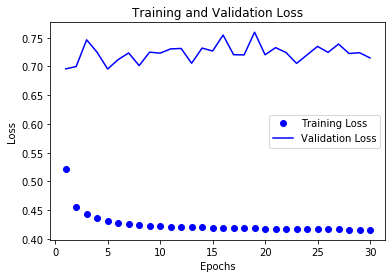

In [211]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

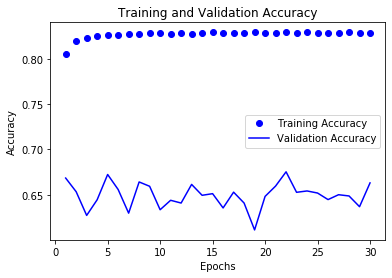

In [212]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

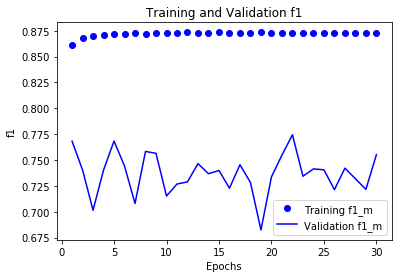

In [213]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [214]:
results = model.evaluate(X_test , y_test)

26753/26753 [==============================] - 1s 42us/sample - loss: 0.7056 - f1_m: 0.7537 - accuracy: 0.6658


In [215]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.7056212624623317
The f1_score is:  0.7537499
The accuracy is:  0.6657571


                      ##### The model get the worst result. It is clear that this data augmentation
                                      method don't works well in this problem. ##### 

# 6) Modifying the N-Gram

- For this section it is necessary to load again the processed data:

In [23]:
data_reviews = pd.read_csv('Data_Processed.csv')

In [24]:
data_reviews.groupby('language').count().sort_values(['recommendation'], ascending=False)['recommendation'].head(5)

language
en    297246
da     13821
so     11103
no      8531
af      7667
Name: recommendation, dtype: int64

In [25]:
data_reviewsEN = data_reviews[data_reviews['language'] == 'en']

In [26]:
data_reviewsEN.shape

(297246, 11)

In [27]:
data_reviewsEN.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language,Label
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en,1.0
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en,1.0
5,2017-09-17,12,228,48,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
7,2018-09-21,2,54,400,False,Recommended,longtime dead daylight player know horror game...,Dead by Daylight,164,en,1.0


In [28]:
data_reviewsEN.groupby('Label').count()['funny']

Label
0.0    101440
1.0    195806
Name: funny, dtype: int64

- Increasing the number from (1,3) to (1,5):

In [29]:
English_reviews = data_reviewsEN.sample(frac=0.7, random_state=1)

In [30]:
vectorizer = CountVectorizer(max_df = 0.9, min_df=0.003, max_features= 2500, binary= False, ngram_range=(1,5))

In [31]:
train = vectorizer.fit_transform(English_reviews['review'])

In [32]:
target = English_reviews['Label']

In [33]:
train = train.toarray()

In [34]:
X_train, x_val_test, y_train, y_val_test = train_test_split(train, target,
                                                    test_size = 0.3,
                                                    random_state = 500
                                                    ,stratify = target)

In [35]:
X_val, X_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                    test_size = 0.3,
                                                    random_state = 200
                                                    ,stratify = y_val_test)

- Using this data for the complex model:

In [36]:
model = Sequential()

model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu', input_dim = len(train[1])))
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                105536    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 109,761
Trainable params: 109,761
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'acc'] )

In [39]:
csv_logger = CSVLogger('model_complex_gram_5.log', separator=',', append=False)

In [40]:
history = model.fit(X_train,
                    y_train,
                    epochs = 30,
                    batch_size = 500,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/30
145650/145650 [==============================] - 4s 26us/sample - loss: 0.6099 - f1_m: 0.8656 - acc: 0.8112 - val_loss: 0.4383 - val_f1_m: 0.8819 - val_acc: 0.8395
Epoch 2/30
145650/145650 [==============================] - 3s 20us/sample - loss: 0.4209 - f1_m: 0.8856 - acc: 0.8445 - val_loss: 0.4106 - val_f1_m: 0.8853 - val_acc: 0.8434
Epoch 3/30
145650/145650 [==============================] - 3s 20us/sample - loss: 0.4049 - f1_m: 0.8882 - acc: 0.8484 - val_loss: 0.4014 - val_f1_m: 0.8875 - val_acc: 0.8475
Epoch 4/30
145650/145650 [==============================] - 3s 23us/sample - loss: 0.3958 - f1_m: 0.8899 - acc: 0.8510 - val_loss: 0.3969 - val_f1_m: 0.8869 - val_acc: 0.8469
Epoch 5/30
145650/145650 [==============================] - 4s 28us/sample - loss: 0.3895 - f1_m: 0.8911 - acc: 0.8527 - val_loss: 0.3934 - val_f1_m: 0.8879 - val_acc: 0.8510
Epoch 6/30
145650/145650 [==============================] - 5s 32us/sample

In [41]:
#Saving the model:
model.save('model_complex_gram_5.h5')

- Plot of the three parameters evaluated in the model:

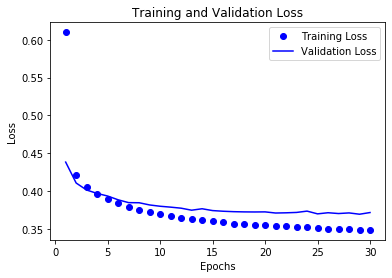

In [42]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

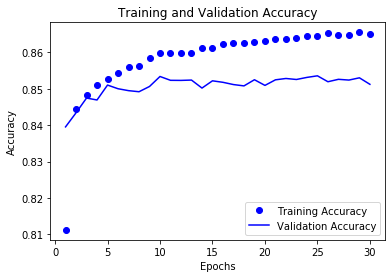

In [43]:
history_dict = history.history
accuracy_values = history_dict['acc']
val_accuracy_values = history_dict['val_acc']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

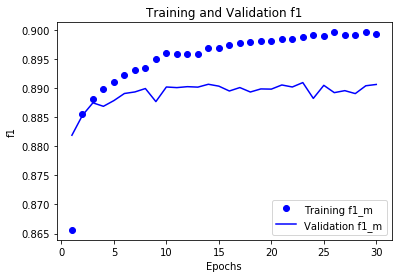

In [44]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [45]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 39us/sample - loss: 0.3633 - f1_m: 0.8915 - acc: 0.8549


In [46]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.36332499676609264
The f1_score is:  0.89154375
The accuracy is:  0.854862


                      ##### The results are really similar to the results got with the original
                      configuration. We can assume that the modification of the n-gram parameters
                                      are not going to improve our results.##### 

# 7) Model with a Flatten layer:

In [47]:
model = Sequential()

model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu', input_dim = len(train[1])))
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.005),activation = 'relu'))
model.add(Flatten())
model.add(Dense(1,activation = 'sigmoid'))

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                105536    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 109,761
Trainable params: 109,761
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m,'accuracy'] )

In [50]:
csv_logger = CSVLogger('model_complex_regularization_flatten.log', separator=',', append=False)

In [51]:
history = model.fit(X_train,
                    y_train,
                    epochs = 30,
                    batch_size = 200,
                    validation_data = (X_val, y_val),
                    callbacks=[csv_logger])

Train on 145650 samples, validate on 43695 samples
Epoch 1/30
145650/145650 [==============================] - 5s 34us/sample - loss: 0.5202 - f1_m: 0.8741 - accuracy: 0.8275 - val_loss: 0.4216 - val_f1_m: 0.8834 - val_accuracy: 0.8443
Epoch 2/30
145650/145650 [==============================] - 4s 29us/sample - loss: 0.4134 - f1_m: 0.8859 - accuracy: 0.8457 - val_loss: 0.4059 - val_f1_m: 0.8856 - val_accuracy: 0.8442
Epoch 3/30
145650/145650 [==============================] - 4s 29us/sample - loss: 0.3999 - f1_m: 0.8885 - accuracy: 0.8495 - val_loss: 0.3985 - val_f1_m: 0.8862 - val_accuracy: 0.8480
Epoch 4/30
145650/145650 [==============================] - 5s 34us/sample - loss: 0.3916 - f1_m: 0.8892 - accuracy: 0.8507 - val_loss: 0.3938 - val_f1_m: 0.8893 - val_accuracy: 0.8497
Epoch 5/30
145650/145650 [==============================] - 6s 42us/sample - loss: 0.3846 - f1_m: 0.8907 - accuracy: 0.8530 - val_loss: 0.3928 - val_f1_m: 0.8851 - val_accuracy: 0.8496
Epoch 6/30
145650/145650

In [52]:
#Saving the model:
model.save('model_complex_regularization_flatten.h5')

- Plot of the three parameters evaluated in the model:

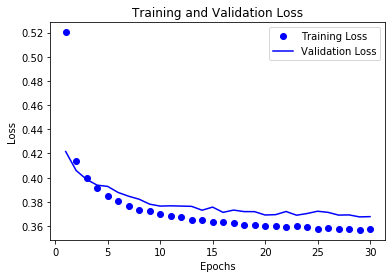

In [53]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

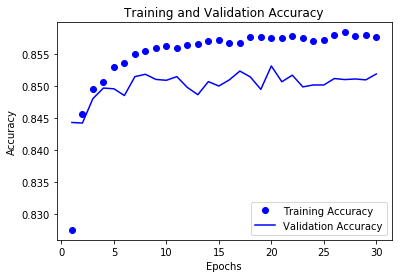

In [54]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

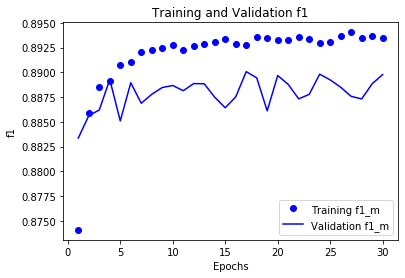

In [55]:
history_dict = history.history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [56]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 45us/sample - loss: 0.3618 - f1_m: 0.8914 - accuracy: 0.8563


In [57]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.36177264321572555
The f1_score is:  0.89143825
The accuracy is:  0.85630375


                         ##### The model don't improve the best result. The Flatten layers doesn't
                                                     improve the results. ##### 

# 8) BEST MODEL PERFORMANCE

- The best model is the one that use:
    - (1,3) N-Gram configuration
    - Regularization parameter equal to 0.005.
    - 2 layers with 32 elements + 1 with sigmoid activation.

### 8.1) Loading the data:

In [3]:
data_reviews = pd.read_csv('Data_Processed.csv')

In [4]:
data_reviews.groupby('language').count().sort_values(['recommendation'], ascending=False)['recommendation'].head(5)

language
en    297246
da     13821
so     11103
no      8531
af      7667
Name: recommendation, dtype: int64

In [5]:
data_reviewsEN = data_reviews[data_reviews['language'] == 'en']

In [6]:
data_reviewsEN.shape

(297246, 11)

In [7]:
data_reviewsEN.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language,Label
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en,1.0
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en,1.0
5,2017-09-17,12,228,48,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
7,2018-09-21,2,54,400,False,Recommended,longtime dead daylight player know horror game...,Dead by Daylight,164,en,1.0


In [8]:
data_reviews.groupby('recommendation').count()['Label']

recommendation
Not Recommended    121306
Recommended        268346
Name: Label, dtype: int64

### 8.2) Preparing the training, validation and test set:

In [64]:
English_reviews = data_reviewsEN.sample(frac=0.7, random_state=1)

- Creating vectors with n-grams between 1 and 3 words:

In [65]:
vectorizer = CountVectorizer(max_df = 0.9, min_df=0.003, max_features= 2500, binary= False, ngram_range=(1, 3))

In [66]:
train = vectorizer.fit_transform(English_reviews['review'])

In [67]:
target = English_reviews['Label']

In [68]:
target

341269    1.0
338420    0.0
280475    1.0
210089    1.0
73039     1.0
         ... 
204180    0.0
81900     1.0
195257    0.0
60691     0.0
148883    1.0
Name: Label, Length: 208072, dtype: float64

In [69]:
train = train.toarray()

In [70]:
train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

- Spitting the data:

In [71]:
X_train, x_val_test, y_train, y_val_test = train_test_split(train, target,
                                                    test_size = 0.3,
                                                    random_state = 500
                                                    ,stratify = target)

In [72]:
X_val, X_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                    test_size = 0.3,
                                                    random_state = 200
                                                    ,stratify = y_val_test)

### 8.3) Loading the model and the callback:

In [73]:
model = load_model('model_complex_regularization.h5',custom_objects= {'f1_m': f1_m})

In [74]:
history = pd.read_csv('model_complex_regularization.log', sep=',', engine='python')

- Plot of the three parameters evaluated in the model:

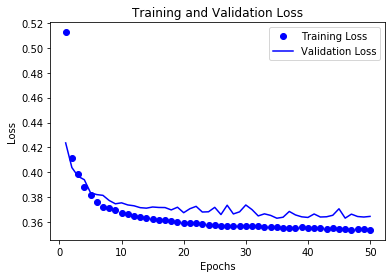

In [75]:
history_dict = history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

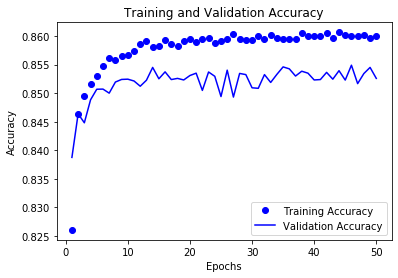

In [76]:
history_dict = history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

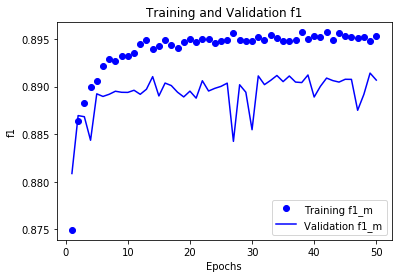

In [77]:
history_dict = history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [78]:
results = model.evaluate(X_test , y_test)

18727/18727 [==============================] - 1s 47us/sample - loss: 0.3587 - f1_m: 0.8925 - accuracy: 0.8569


In [79]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.3587223973005665
The f1_score is:  0.89248043
The accuracy is:  0.8569445


### 8.4) Confusion Matrix

In [80]:
predictions = model.predict(X_test)

In [81]:
# round predictions 
predictions = [round(x[0]) for x in predictions]

In [82]:
true_classes = y_test

In [86]:
import matplotlib.pyplot as plt

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w",fontdict = {'size': 18})

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    fig.set_size_inches(18.5, 10.5)
    return plt.show()

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.


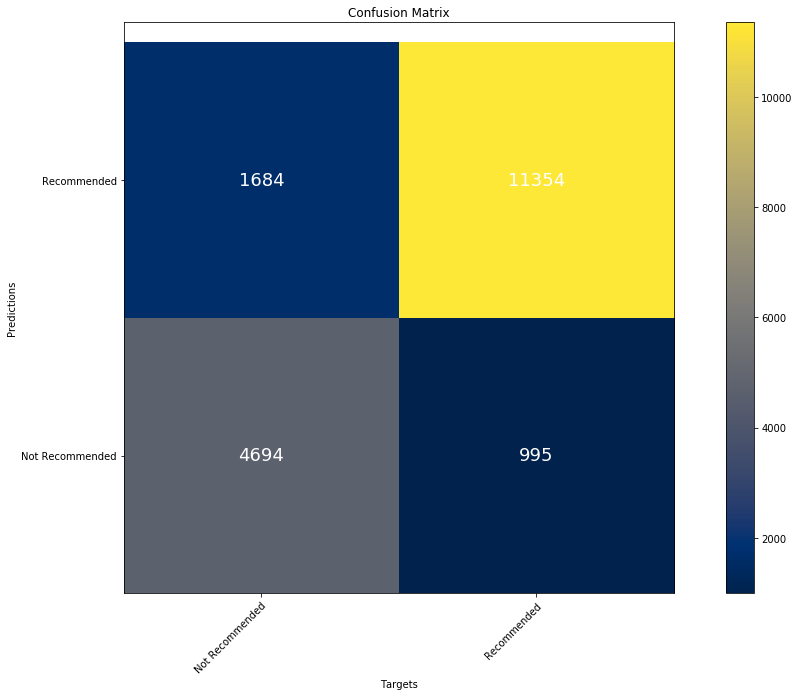

In [87]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predictions, true_classes)
plot_cm(confusion_matrix(predictions, true_classes), ['Not Recommended','Recommended'])

# 9) Embeddings

In [9]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vgonz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
data_reviews.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,language,Label
0,2019-02-10,2,4,578,False,Recommended,gt played german reich gt declare war belgium ...,Expansion - Hearts of Iron IV: Man the Guns,26,nl,1.0
1,2019-02-07,0,0,892,False,Recommended,good game although bit overpriced opinion pref...,Expansion - Hearts of Iron IV: Man the Guns,17,en,1.0
2,2018-06-14,126,1086,676,False,Recommended,review wrote one probably serious one wrote st...,Dead by Daylight,191,en,1.0
3,2017-06-20,85,2139,612,False,Recommended,disclaimer survivor main play game fun competi...,Dead by Daylight,132,en,1.0
4,2016-12-12,4,55,2694,False,Recommended,english playing two year given task reviewing ...,Dead by Daylight,567,es,1.0


In [11]:
data = list(data_reviews['review'])
target = list(data_reviews['Label'])

- The first parameter to the Embedding() layer is the vocabulary (number of unique words in the data):

In [12]:
all_words = []
for review in data:
    tokenize_word = word_tokenize(review)
    for word in tokenize_word:
        all_words.append(word)

In [13]:
unique_words = set(all_words)
vocabulary_length = len(unique_words)
print(vocabulary_length)

162613


- Using the "one_hot" function. The function takes sentence and the total length of the vocabulary and returns the sentence in numeric form.

In [14]:
embedded_reviews = [one_hot(review, vocabulary_length) for review in data]
print(embedded_reviews)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



- Due to the limitation of memory in the computers of the group, the maximum size for the vectors is 2500.

In [17]:
padded_reviews = pad_sequences(embedded_reviews, 2500, padding='post')

In [18]:
print(padded_reviews)

[[ 56803  76021 104196 ...      0      0      0]
 [ 70181  59981 153485 ...      0      0      0]
 [105900 111723   8904 ...      0      0      0]
 ...
 [ 93113  36308 118195 ...      0      0      0]
 [161041 154429 104888 ...      0      0      0]
 [ 77092 105715  13889 ...      0      0      0]]


- Splitting:

In [19]:
X_train, x_val_test, y_train, y_val_test = train_test_split(padded_reviews, target,
                                                    test_size = 0.3,
                                                    random_state = 500
                                                    ,stratify = target)

In [20]:
X_val, X_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                    test_size = 0.3,
                                                    random_state = 200
                                                    ,stratify = y_val_test)

- Building the model:

In [21]:
model = Sequential()

model.add(Embedding(vocabulary_length, 20, input_length=2500))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m,'acc'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2500, 20)          3252260   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50001     
Total params: 3,302,261
Trainable params: 3,302,261
Non-trainable params: 0
_________________________________________________________________


In [24]:
csv_logger = CSVLogger('model_embeddings.log', separator=',', append=False)

In [25]:
model.fit(padded_reviews, target, epochs=10, verbose=1, validation_data = (X_val, y_val), callbacks=[csv_logger])

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 389652 samples, validate on 81827 samples
Epoch 1/10
389652/389652 [==============================] - 1925s 5ms/step - loss: 0.3420 - f1_m: 0.8966 - acc: 0.8555 - val_loss: 0.2910 - val_f1_m: 0.9122 - val_acc: 0.8761
Epoch 2/10
389652/389652 [==============================] - 1922s 5ms/step - loss: 0.2969 - f1_m: 0.9119 - acc: 0.8788 - val_loss: 0.2535 - val_f1_m: 0.9267 - val_acc: 0.8994
Epoch 3/10
389652/389652 [==============================] - 1914s 5ms/step - loss: 0.2606 - f1_m: 0.9235 - acc: 0.8951 - val_loss: 0.2133 - val_f1_m: 0.9395 - val_acc: 0.9173
Epoch 4/10
389652/389652 [==============================] - 1912s 5ms/step - loss: 0.2231 - f1_m: 0.9355 - acc: 0.9119 - val_loss: 0.1798 - val_f1_m: 0.9495 - val_acc: 0.9310
Epoch 5/10
389652/389652 [==============================] - 1913s 5ms/step - loss: 0.1925 - f1_m: 0.9450 - acc: 0.9251 - val_loss: 0.1657 - val_f1_m: 0.9519 - val_acc: 0.9330
Epoch 6/10
389652/389652 [==============================] - 1913s 5ms/step

In [26]:
#Saving the model:
model.save('model_embeddings.h5')

- Plot of the three parameters evaluated in the model:

In [28]:
history = pd.read_csv('model_embeddings.log', sep=',', engine='python')

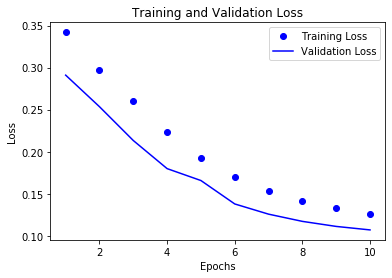

In [30]:
history_dict = history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

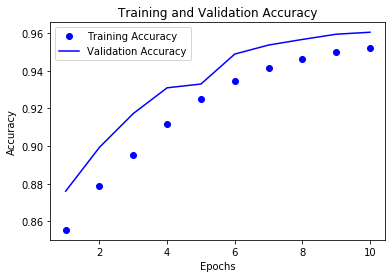

In [32]:
history_dict = history
accuracy_values = history_dict['acc']
val_accuracy_values = history_dict['val_acc']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

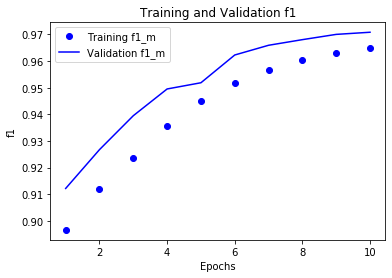

In [33]:
history_dict = history
accuracy_values = history_dict['f1_m']
val_accuracy_values = history_dict['val_f1_m']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training f1_m')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation f1_m')
plt.title('Training and Validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()

- Evaluating the model with the test set:

In [34]:
results = model.evaluate(X_test , y_test)

35069/35069 [==============================] - 15s 439us/step


In [35]:
print('The loss is: ', results[0])
print('The f1_score is: ', results[1])
print('The accuracy is: ', results[2])

The loss is:  0.10382410962129394
The f1_score is:  0.9711053371429443
The accuracy is:  0.9609912037849426


                      ##### The results are the highest got it. It shows how the embedding approach 
                is a computational expensive solution but it get the best results. Due to the limitation of
                      the computers of the team, we are not able to try deeper networks but it is 
                   enough to demostrate that it is the best possible approach in terms of accuracy ##### 

- Confusion Matrix

In [36]:
predictions = model.predict(X_test)

In [37]:
# round predictions 
predictions = [round(x[0]) for x in predictions]

In [38]:
true_classes = y_test

In [39]:
import matplotlib.pyplot as plt

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w",fontdict = {'size': 18})

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    fig.set_size_inches(18.5, 10.5)
    return plt.show()

D:\Programs_Inst\Anaconda\envs\Deep Learning\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.


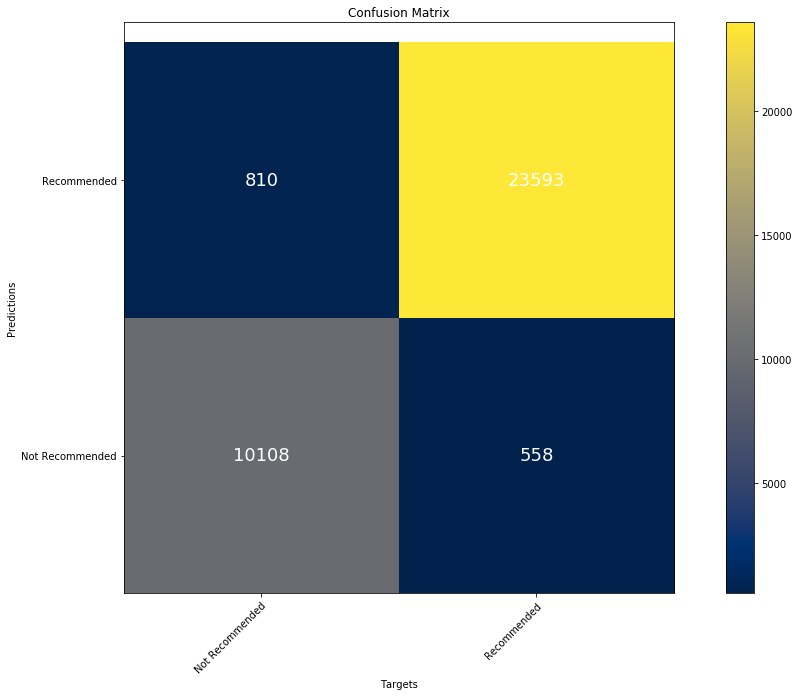

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predictions, true_classes)
plot_cm(confusion_matrix(predictions, true_classes), ['Not Recommended','Recommended'])